In [13]:
import pandas as pd

data = pd.read_csv('nsl-kdd.csv')
data.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


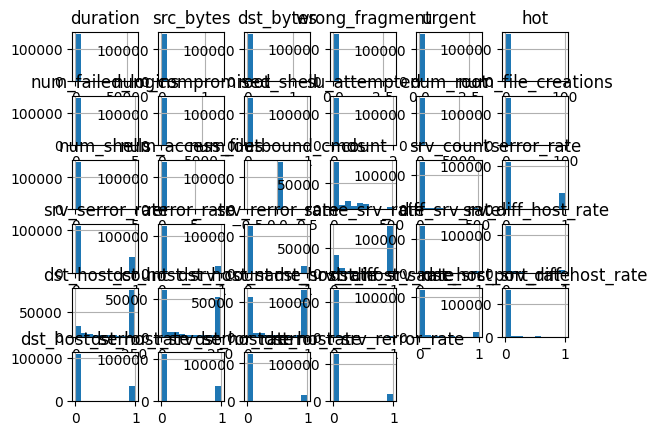

In [14]:
import matplotlib.pyplot as plt

freqgraph = data.select_dtypes(include=["float"])
freqgraph.hist()
plt.show()


Mutual Information Scores:
src_bytes                      0.542678
dst_bytes                      0.437492
service                        0.434002
flag                           0.338065
same_srv_rate                  0.328913
diff_srv_rate                  0.320513
dst_host_srv_count             0.302225
dst_host_same_srv_rate         0.278945
logged_in                      0.264642
dst_host_diff_srv_rate         0.259576
dst_host_serror_rate           0.239895
serror_rate                    0.235771
count                          0.234296
dst_host_srv_serror_rate       0.232838
srv_serror_rate                0.223356
dst_host_srv_diff_host_rate    0.173179
dst_host_count                 0.137067
dst_host_same_src_port_rate    0.129467
srv_diff_host_rate             0.098674
dst_host_srv_rerror_rate       0.064341
rerror_rate                    0.055661
protocol_type                  0.054081
dst_host_rerror_rate           0.052164
srv_rerror_rate                0.052009
srv_count   

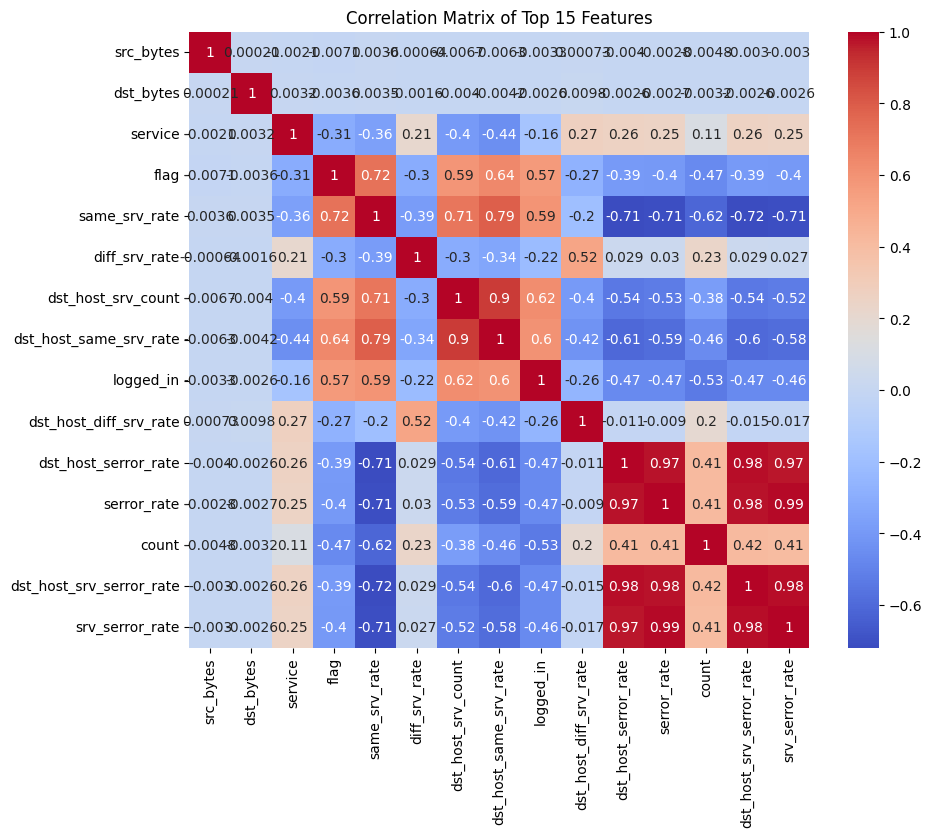


Final selected features after removing correlated ones:
Index(['src_bytes', 'dst_bytes', 'service', 'flag', 'same_srv_rate',
       'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'logged_in', 'dst_host_diff_srv_rate', 'dst_host_serror_rate', 'count'],
      dtype='object')

Selected list of features:
['src_bytes', 'dst_bytes', 'service', 'flag', 'same_srv_rate', 'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'logged_in', 'dst_host_diff_srv_rate', 'dst_host_serror_rate', 'count']

Final dataset shape: (148517, 12)


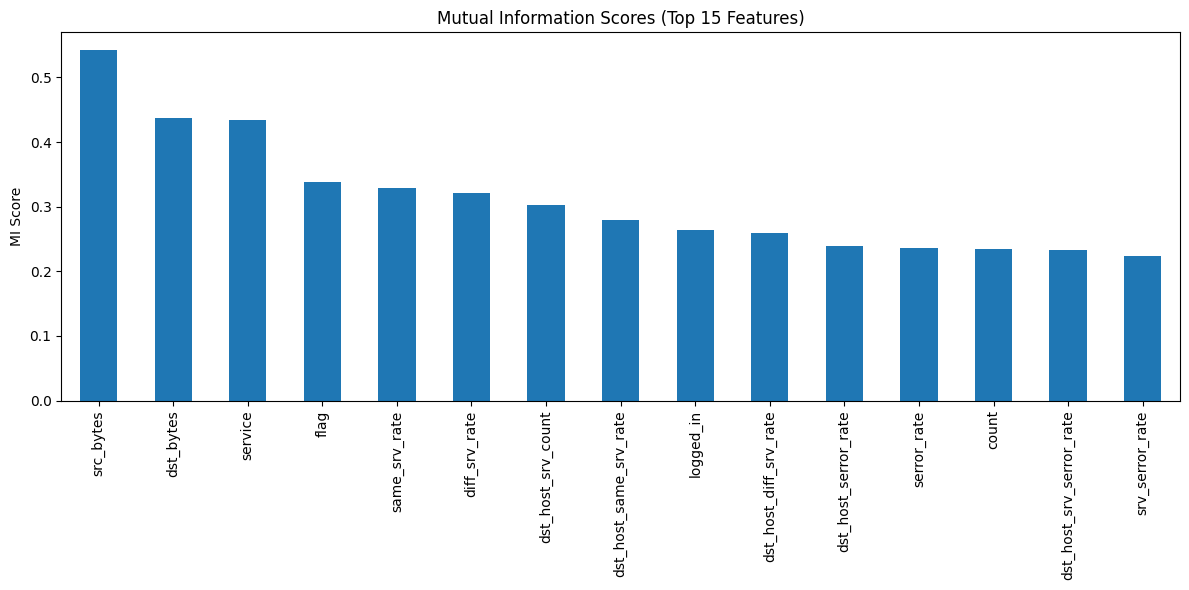

In [15]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('nsl-kdd.csv')

# Separate features and target
X = df.drop(columns=['class'])
y = df['class']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=[object]).columns.tolist()

# Encode categorical features using Label Encoding
for col in categorical_features:
    X[col] = label_encoder.fit_transform(X[col])

# Scale numeric features
scaler = MinMaxScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# --- Mutual Information ---
mi_scores = mutual_info_classif(X, y_encoded, random_state=0)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores:")
print(mi_scores)

# Select top 15 features based on Mutual Information scores
top_15_features = mi_scores.index[:15]
print("\nTop 15 features based on Mutual Information:")
print(top_15_features)

# Filter X to only include the top 15 features
X_top_15 = X[top_15_features]

# --- Correlation Matrix for selected top 15 features ---
plt.figure(figsize=(10, 8))
corr_matrix = X_top_15.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Top 15 Features")
plt.show()

# Remove highly correlated features (correlation > 0.9)
threshold = 0.9
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Final selected features after removing highly correlated ones
final_selected_features = top_15_features.drop(to_drop)
print("\nFinal selected features after removing correlated ones:")
print(final_selected_features)

# Assign combined top features to a list named selected_list
selected_list = final_selected_features.tolist()
print("\nSelected list of features:")
print(selected_list)

# Filter X to include only final selected features
X_final = X[selected_list]

# Display the final feature set
print("\nFinal dataset shape:", X_final.shape)

# --- Visualization ---

# Plot Mutual Information Scores for top 15 features
plt.figure(figsize=(12, 6))
mi_scores[top_15_features].plot(kind='bar')
plt.title('Mutual Information Scores (Top 15 Features)')
plt.ylabel('MI Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [16]:
print(data.isnull().sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


# Assuming the 'class' column contains 'normal' and 'anomaly'
labelencoder = LabelEncoder()
data['service'] = label_encoder.fit_transform(data['service'])
data['flag'] = label_encoder.fit_transform(data['flag'])




# Normalize numerical features
scaler = StandardScaler()
data[selected_list] = scaler.fit_transform(data[selected_list])

x = data[selected_list]
y = label_encoder.fit_transform(data['class'])


 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.neural_network import MLPClassifier

# Initialize MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)

# Train the model
mlp.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)

In [19]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the test set
y_pred = mlp.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9901696741179639
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     14254
           1       0.99      0.99      0.99     15450

    accuracy                           0.99     29704
   macro avg       0.99      0.99      0.99     29704
weighted avg       0.99      0.99      0.99     29704

